<a href="https://colab.research.google.com/github/ParitoshP702/Credit_Risk_Analysis/blob/main/Credit_Risk_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this module we will try  to model the credit risk using ML algorithms.First we are going to divide the borrowers into different groups based on riskiness.  

# Risk Bucketing:

In [2]:
import pandas as pd
credit = pd.read_csv("/content/german_credit_data.csv")

In [3]:
credit

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [4]:
#dropping the unneccesary columns unnamed
del credit["Unnamed: 0"]

In [5]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


We will examine the distribution of our variables using histogram.

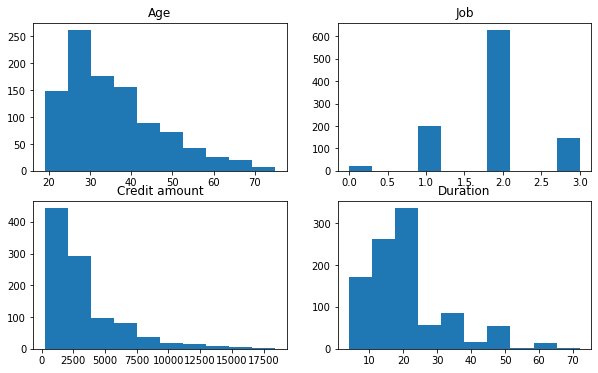

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
numerical_credit = credit.select_dtypes(exclude ="O")#dropping the object type variables to obtain all numerical data
plt.figure(figsize = (10,6))
k = 0 
cols = numerical_credit.columns
for i,j in zip(range(len(cols)), cols):
  k += 1
  plt.subplot(2,2,k)
  plt.hist(numerical_credit.iloc[:,i])
  plt.title(j)

It turns out that non of our variables follow normal distribution.


Now we will use different methods to find the optimum number of clusters , the first being: 
# Elbow Method

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [8]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)#Appllying standarization for scaling purpose
distance = []
for k in range(1,10):
  kmeans = KMeans(n_clusters = k)#Running K means algorithm
  kmeans.fit(scaled_credit)
  distance.append(kmeans.inertia_)#calculating inertia and storing into a list named distance
  

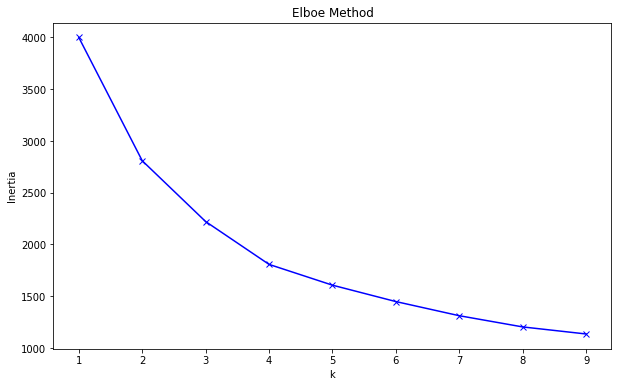

In [9]:
plt.plot(range(1,10), distance,"bx-")
plt.xlabel('k')
plt.ylabel("Inertia")
plt.title("Elboe Method")
plt.show()

In the above figure , our curve flattens after 4, hence elbow method suggests that we stop at four clusters.

# Silhouette score method

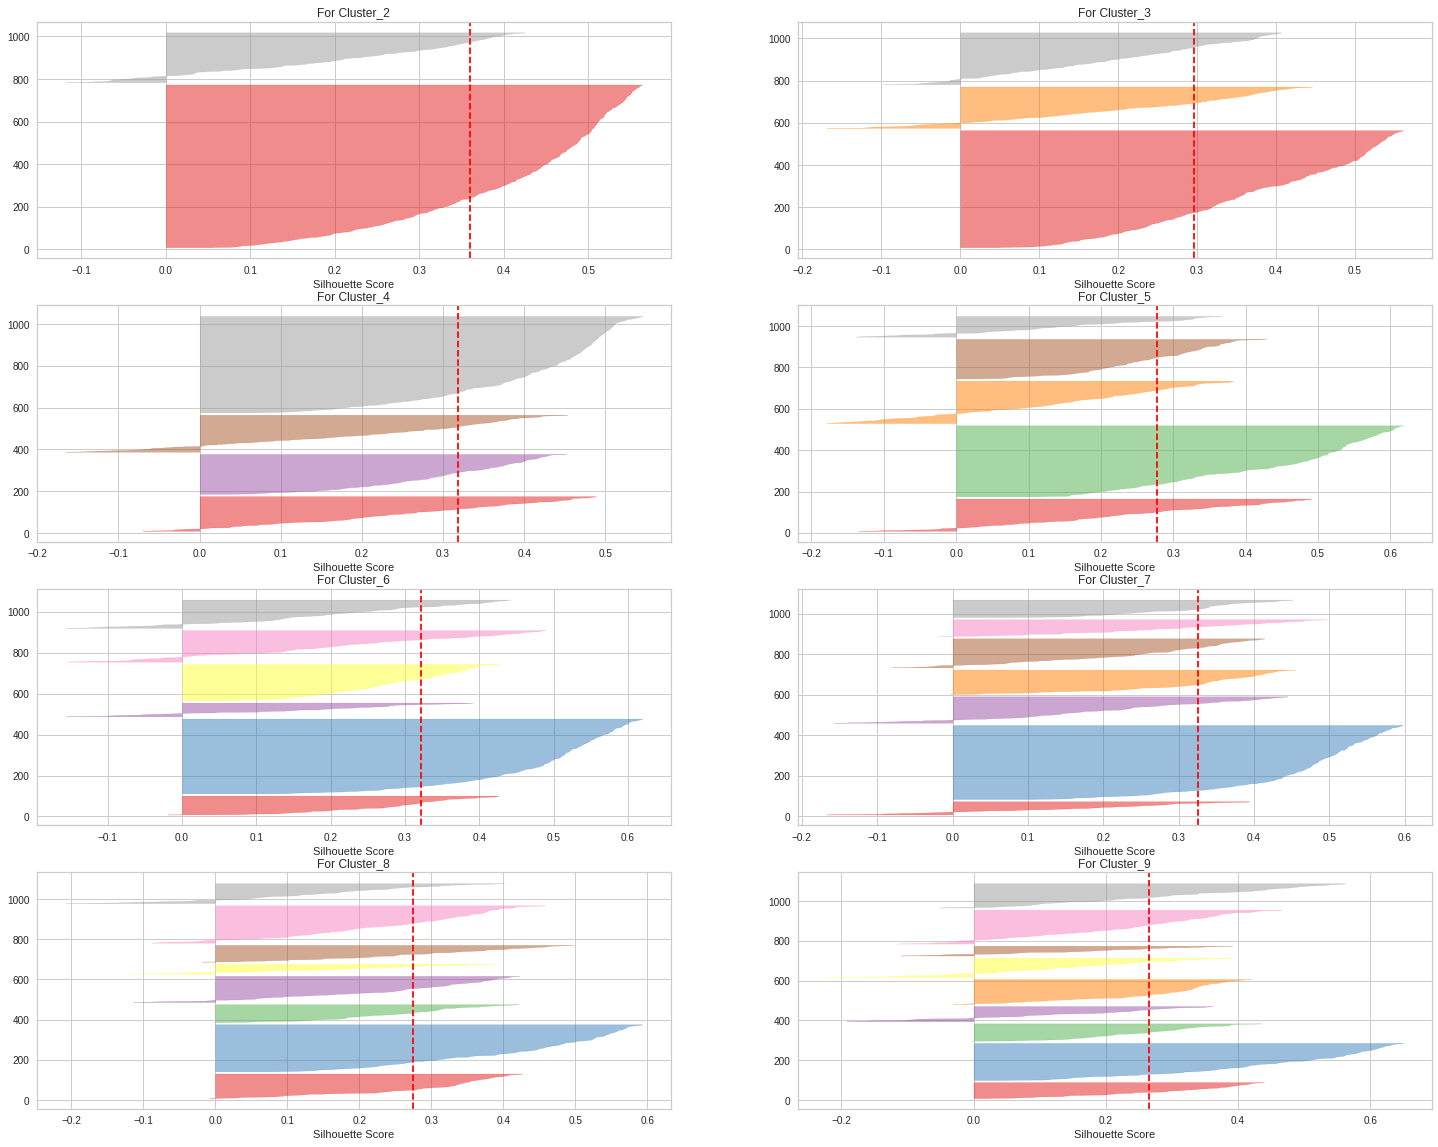

In [10]:
from sklearn.metrics import silhouette_score#importing the module
from yellowbrick.cluster import SilhouetteVisualizer#importing the module to drwa th silhoutte plots
fig, ax = plt.subplots(4,2, figsize = (25,20))
for i in range(2,10):
  km = KMeans(n_clusters = i)
  q,r = divmod(i,2)#using divmod to configure labels
  visualizer = SilhouetteVisualizer(km, color = "yellowbrick", ax = ax[q-1][r])
  visualizer.fit(scaled_credit)
  ax[q-1][r].set_title("For Cluster_"+str(i))
  ax[q-1][r].set_xlabel("Silhouette Score")


Hence the Silhouette score method suggests that the appropriate cluster size is 2.Now, we will use the CH score to determine the required number of clusters.

# Calinski-Harabasz score:

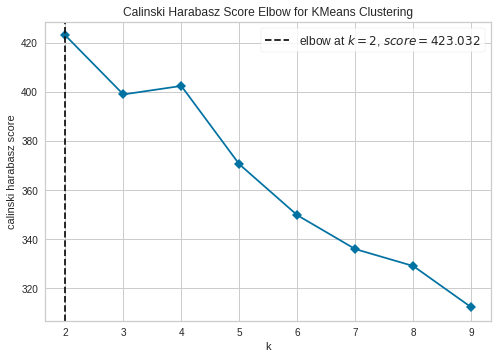

In [11]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k = (2,10), metric = "calinski_harabasz", timings = False)
visualizer.fit(scaled_credit)
visualizer.show()

This method also suggeststhe appropriate number of clusters = 2

In light of these methods, 2 clusters are chosen to be optimal number of clusters and the K-means clustering analysis is conducted accordingly. Let us visualize the 2D clusters using the following data:


In [12]:
kmeans = KMeans(n_clusters = 2)
clusters = kmeans.fit_predict(scaled_credit)

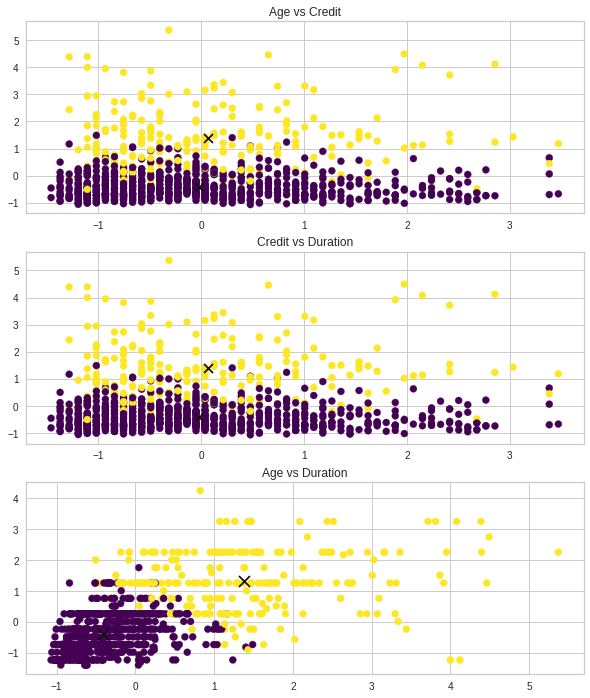

In [13]:
plt.figure(figsize = (10,12))
plt.subplot(311)
plt.scatter(scaled_credit[:,0], scaled_credit[:,2], c= kmeans.labels_, cmap = "viridis")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,2], s = 80, marker = "x", color = "k")
plt.title("Age vs Credit")
plt.subplot(312)
plt.scatter(scaled_credit[:,0],scaled_credit[:,2], c= kmeans.labels_,cmap = "viridis")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,2], s = 80, marker = "x", color=  "k")
plt.title("Credit vs Duration")
plt.subplot(313)
plt.scatter(scaled_credit[:,2],scaled_credit[:,3], c = kmeans.labels_, cmap = "viridis")
plt.scatter(kmeans.cluster_centers_[:,2],kmeans.cluster_centers_[:,3], s = 120, marker = "x",color = "k")
plt.title("Age vs Duration")
plt.show()


# Probablity of default estimation with logistic regression.

In [14]:
clusters, counts = np.unique(kmeans.labels_, return_counts = True)#obtaining cluster numbers
#differentiating the clusters and sorting them into a dictionary
cluster_dict = {}
for i in range(len(clusters)):
  cluster_dict[i] = scaled_credit[np.where(kmeans.labels_==i)]
credit["clusters"] = pd.DataFrame(kmeans.labels_)
df_scaled=  pd.DataFrame(scaled_credit)
df_scaled["clusters"] = credit["clusters"]
df_scaled["Risk"] = credit["Risk"]
df_scaled.columns = ["Age","Job","Credit amount", "Duration","Clusters","Risk"]


In [15]:
df_scaled[df_scaled.Clusters == 0]["Risk"].value_counts()#number of observation categories within a cluster



good    576
bad     195
Name: Risk, dtype: int64

In [16]:
df_scaled[df_scaled.Clusters == 1]["Risk"].value_counts()#finding the number of observations per category

good    124
bad     105
Name: Risk, dtype: int64

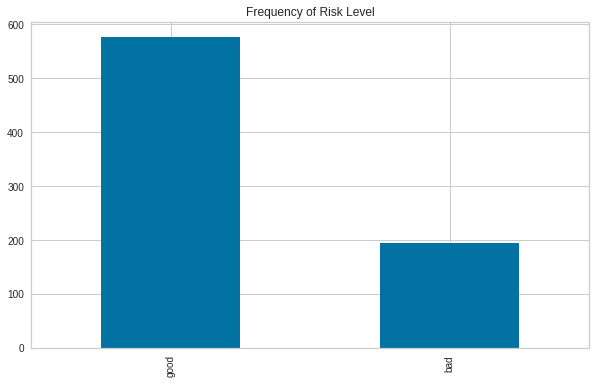

In [17]:
#Then we draw a number of barplots to show the difference of observations per risk level category
df_scaled[df_scaled.Clusters == 0]["Risk"].value_counts().plot(kind = "bar", figsize = (10,6), title = "Frequency of Risk Level")


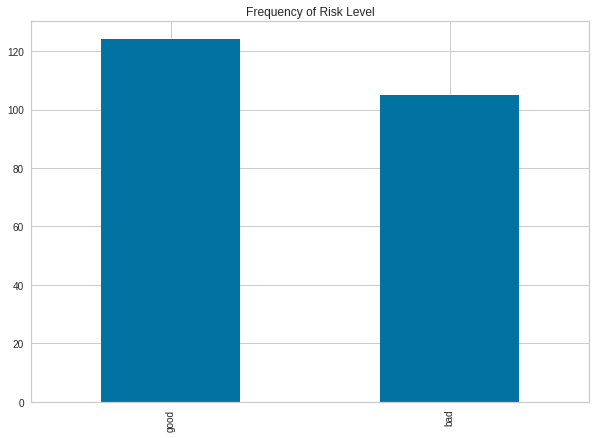

In [18]:
df_scaled[df_scaled.Clusters == 1]["Risk"].value_counts().plot(kind = "bar",figsize = (10,7), title = "Frequency of Risk Level")

Now we will split the data into training and testing parts.

In [19]:
from sklearn.model_selection import train_test_split
df_scaled["Risk"] = df_scaled["Risk"].replace({"good":1,"bad":0})
x = df_scaled.drop("Risk", axis = 1)
y = df_scaled.loc[:,["Risk","Clusters"]]


In [20]:
x_train,x_test,y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)


In [21]:
first_cluster_train = x_train[x_train.Clusters == 0].iloc[:,:-1]
second_cluster_train = x_train[x_train.Clusters == 1].iloc[:,:-1]

After this we are ready to move ahead and run the loggistic regresssion to predict the probablity of default.

In [22]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN#importing SMOTEENN to deal with the imbalance problem
import warnings
warnings.filterwarnings("ignore")

In [23]:
x_train1 = first_cluster_train
y_train1 = y_train[y_train.Clusters == 0]["Risk"]#creating significant data based on cluster 1
smote = SMOTEENN(random_state = 2)
x_train1, y_train1 = smote.fit_resample(x_train1,y_train1.ravel())#tuning the imbalanced data to balanced data
logit = sm.Logit(y_train1,x_train1)#configuring logistic regression model
logit_fit1 = logit.fit()#running the logistic regression model
print(logit_fit1.summary())


Optimization terminated successfully.
         Current function value: 0.430540
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  401
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.3709
Time:                        04:39:27   Log-Likelihood:                -172.65
converged:                       True   LL-Null:                       -274.44
Covariance Type:            nonrobust   LLR p-value:                 7.086e-44
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               1.7796      0.193      9.232      0.000       1.402       2.157
Job               0.

Following analysis is done with test data

In [24]:
first_test_cluster = x_test[x_test.Clusters == 0].iloc[:,:-1]
second_test_cluster = x_test[x_test.Clusters == 1].iloc[:,:-1]

In [25]:
x_test1 = first_test_cluster
y_test1 = y_test[y_test.Clusters == 0]["Risk"]
pred_prob1 = logit_fit1.predict(x_test1)#compute the roc-auc score

In [26]:
false_pos, true_pos, _ = roc_curve(y_test1.values, pred_prob1)#obtaining false and true positives using roc-auc curve

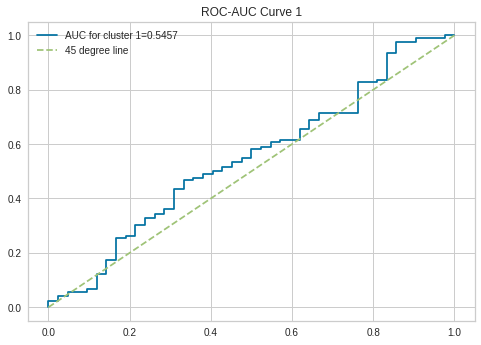

In [27]:
auc = roc_auc_score(y_test1, pred_prob1)#compute roc-auc score
plt.plot(false_pos, true_pos, label = "AUC for cluster 1={:.4f}".format(auc))
plt.plot([0,1],[0,1],linestyle = "--", label = "45 degree line")
plt.legend(loc = "best")
plt.title("ROC-AUC Curve 1")
plt.show()

We can say that the perfomance of the model is not very good, as the roc-auc curve moves just close to the 45 degree line. Generally speaking given a test set , an appropriate roc-auc curve must be close to 1, stating perfect to close relation.

In [30]:
x_train2 = second_cluster_train
y_train2 = y_train[y_train.Clusters == 1]["Risk"]
logit = sm.Logit(y_train2,x_train2)
logit_fit2 = logit.fit()
print(logit_fit2.summary())


Optimization terminated successfully.
         Current function value: 0.688167
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  193
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                0.001590
Time:                        04:39:42   Log-Likelihood:                -132.82
converged:                       True   LL-Null:                       -133.03
Covariance Type:            nonrobust   LLR p-value:                    0.9354
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.0120      0.149     -0.081      0.936      -0.304       0.280
Job               0.

In [32]:
x_test2 = second_test_cluster
y_test2 = y_test[y_test.Clusters == 1]["Risk"]
pred_prob2 = logit_fit2.predict(x_test2)

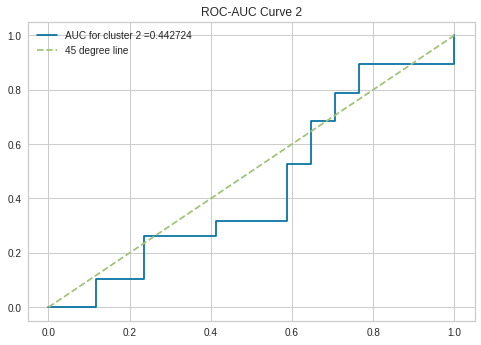

In [34]:
false_pos, true_pos,_ = roc_curve(y_test2.values, pred_prob2)
auc = roc_auc_score(y_test2, pred_prob2)
plt.plot(false_pos, true_pos, label = "AUC for cluster 2 ={:4f}".format(auc))
plt.plot([0,1],[0,1],linestyle = "--", label = "45 degree line")
plt.legend(loc = "best")
plt.title("ROC-AUC Curve 2")
plt.show()

This result is even worse than the previous result.Hence we are far from saying that the logistic regression is doing a good job in modelling probablity of default using german crdit risk dataset.

# Probablity of default estimation with Bayesian Model

In [36]:
pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 8.3 MB/s 
     |████████████████████████████████| 1.8 MB 49.1 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=d6de0f3ebbb8fcc913daa651acd7a0a00eacb26a3c7542058c2a3f0d8ba74758
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [37]:
import pymc3 as pm
import arviz as az

In [40]:
with pm.Model() as logistic_model1:
  beta_age = pm.Normal("coeff_age",mu = 0, sd = 10)
  beta_job = pm.Normal("coeff_job", mu = 0, sd = 10)
  beta_credit = pm.Normal("coeff_credit_amount", mu = 0, sd= 10)
  beta_dur = pm.Normal("coeff_duration", mu = 0, sd =10)
  p = pm.Deterministic("p",pm.math.sigmoid(beta_age*x_train1["Age"]+beta_job*x_train1["Job"]+beta_credit*x_train1["Credit amount"]+beta_dur+x_train1["Duration"]))

In [41]:
with logistic_model1:
  observed = pm.Bernoulli("risk",p, observed = y_train1)#running a bernoulli distribution to model the dependent variable
  map_estimate = pm.find_MAP()#fitting MAP model to data

In [42]:
param_list = ["coeff_age","coeff_job","coeff_credit_amount","coeff_duration"]
params = {}
for i in param_list:
  params[i] = [np.round(map_estimate[i],6)]
  #storing all the results of estimated params with six decimals
  bayesian_params = pd.DataFrame.from_dict(params)
  print("The result of Bayesian estimation:\n{}".format(bayesian_params))

The result of Bayesian estimation:
   coeff_age
0      1.936
The result of Bayesian estimation:
   coeff_age  coeff_job
0      1.936   0.569148
The result of Bayesian estimation:
   coeff_age  coeff_job  coeff_credit_amount
0      1.936   0.569148             0.231186
The result of Bayesian estimation:
   coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0      1.936   0.569148             0.231186          0.5547


The most striking observation is that the difference between estimated coefficients is so small that they can be ignored.


Analysing the result with second cluster data.

In [46]:
with pm.Model() as logistic_model2:
  beta_age = pm.Normal("coeff_age", mu = 0, sd = 10)
  beta_job = pm.Normal("coeff_job", mu = 0, sd = 10)
  beta_credit = pm.Normal("coeff_credit_amount", mu = 0, sd = 10)
  beta_dur = pm.Normal("coeff_duration", mu =0, sd = 10)
  p = pm.Deterministic("p", pm.math.sigmoid(beta_age*second_cluster_train["Age"]+beta_job * second_cluster_train["Job"]+beta_credit*second_cluster_train["Credit amount"]+beta_dur*second_cluster_train["Duration"]))

In [47]:
with logistic_model2:
  observed = pm.Bernoulli("risk",p, observed = y_train[y_train.Clusters == 1]["Risk"])
  map_estimate = pm.find_MAP() 

In [48]:
param_list = ["coeff_age","coeff_job","coeff_credit_amount","coeff_duration"]
params = {}
for i in param_list:
  params[i] = [np.round(map_estimate[i],6)]
  bayesian_params = pd.DataFrame.from_dict(params)
  print("The result of Bayesian estimation:\n {}".format(bayesian_params))

The result of Bayesian estimation:
    coeff_age
0  -0.012017
The result of Bayesian estimation:
    coeff_age  coeff_job
0  -0.012017   0.178658
The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount
0  -0.012017   0.178658            -0.102575
The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0  -0.012017   0.178658            -0.102575        0.078601


Instead of finding the local maximum we now look for an approximate expectation based on sampling procedure.This is known as Markov Chain Monte Carlo (MCMC) in Bayesian Setting.

We will apply Bayesian analysis using Metropolis-Hastings algorithm.

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


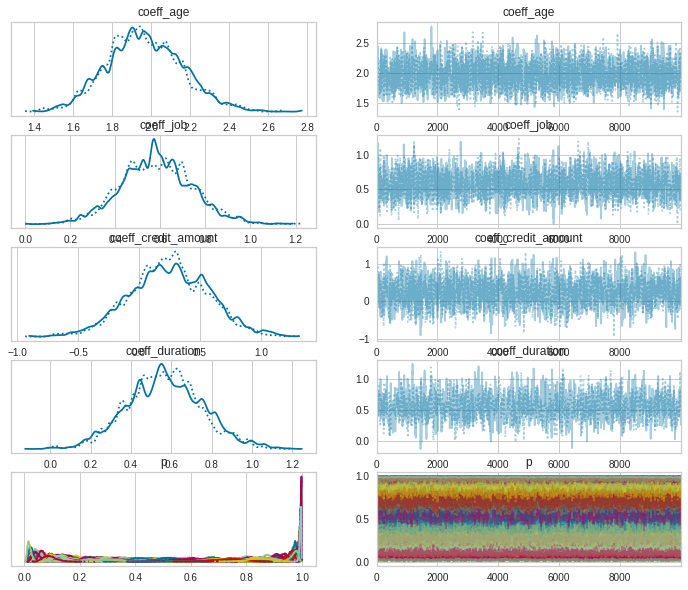

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,1.966568,0.192799,1.613550,2.327475,0.004136,0.002925,2164.692121,2683.882532,1.000832
coeff_job,0.582261,0.159351,0.271552,0.875161,0.003302,0.002335,2318.510131,2486.721527,1.001225
coeff_credit_amount,0.245167,0.320428,-0.335594,0.862220,0.009688,0.006852,1093.021539,1914.909734,1.001671
coeff_duration,0.566529,0.185140,0.217459,0.912290,0.005989,0.004236,953.783040,1534.819500,1.000646


In [50]:
import logging#importing logging package to supress warning message
logger = logging.getLogger("pymc3")#naming the package for logging
logger.setLevel(logging.ERROR)#supressing errors without raising exceptions
with logistic_model1:
  step = pm.Metropolis()#Initialize the MH model
  trace = pm.sample(10000, step = step, progressbar = False)
az.plot_trace(trace)
plt.show()
with logistic_model1:
  display(az.summary(trace, round_to = 6)[:4])

The result shows that the predictive performances are supposed to be very close to that of logistic regression, as the estimated coefficients of these models are quite similar.

However the rsults obtained from MAP application are better probably because MH works with random samples

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


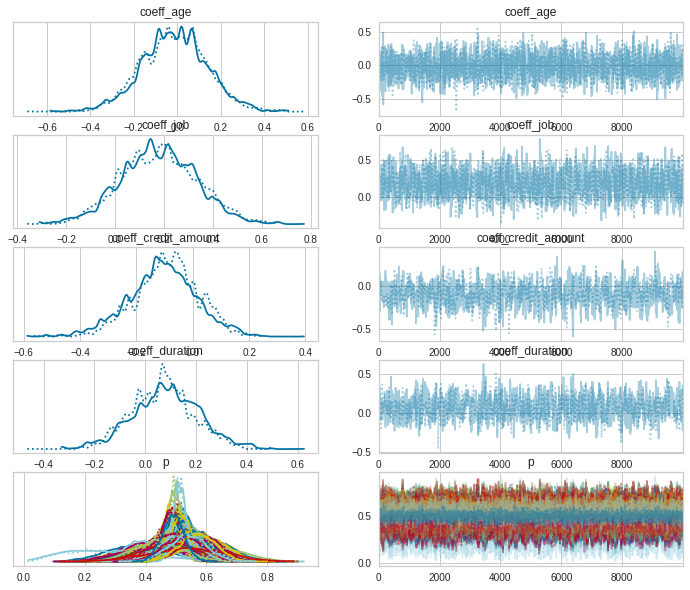

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,-0.012936,0.149390,-0.296581,0.264071,0.002926,0.002224,2605.931831,2668.312925,1.000653
coeff_job,0.179826,0.155507,-0.111740,0.471805,0.003916,0.002770,1577.148815,2143.225343,1.004543
coeff_credit_amount,-0.100065,0.116900,-0.329924,0.108570,0.004477,0.003167,686.978348,1029.798568,1.004771
coeff_duration,0.075740,0.126516,-0.158373,0.314350,0.004555,0.003222,772.972906,1363.142657,1.006922


In [51]:
with logistic_model2:
  step = pm.Metropolis()
  trace = pm.sample(10000,step = step, progressbar = False)
az.plot_trace(trace)
plt.show()
with logistic_model2:
  display(az.summary(trace, round_to = 6)[:4])

Some of the problems with the MH model is that it is very sensitive to the step size.Small step size hinder the convergence rate while large step size may cause a high rejection rate.

Now let's consider what happens when we use the SVM to predict the probablity of default and compare it's performance with the logistic regression.

# Probablity of Default using SVM:
SVM is thought to be a parametric model , it works well with high dimensional data.So the probablity of default case in multivariate setting may rpovide fertile ground for running SVM. 

In [59]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import time

In [60]:
param_svc = {"gamma":[1e-6,1e-2],"C":[0.001,.09,1,5,10],"kernel":("linear","rbf")}
svc = SVC(class_weight = "balanced")
halve_SVC = HalvingRandomSearchCV(svc, param_svc, scoring = "roc_auc",n_jobs = 1)
halve_SVC.fit(x_train1,y_train1)
print("Best hyperparamters for the first cluster in SVC{} with {}".format(halve_SVC.best_score_, halve_SVC.best_params_))


Best hyperparamters for the first cluster in SVC0.8435070543491596 with {'kernel': 'linear', 'gamma': 0.01, 'C': 10}


In [62]:
y_pred_SVC1 = halve_SVC.predict(x_test1)#running a prediction analysis
print("The ROC AUC score of SVC for first cluster is {:4f}".format(roc_auc_score(y_test1,y_pred_SVC1)))

The ROC AUC score of SVC for first cluster is 0.543130


Analysing the model on our second set of clusters

In [63]:
halve_SVC.fit(x_train2,y_train2)
print("Best hyperparametrs for second cluster in SVC {} with {}".format(halve_SVC.best_score_, halve_SVC.best_params_))

Best hyperparametrs for second cluster in SVC 0.5244727238848755 with {'kernel': 'linear', 'gamma': 0.01, 'C': 0.09}


In [64]:
y_pred_SVC2  =halve_SVC.predict(x_test2)
print("The ROC-AUC score of SVC for second cluster is {:4f}".format(roc_auc_score(y_test2,y_pred_SVC2)))

The ROC-AUC score of SVC for second cluster is 0.633127


Hence we can see that the SVC approach works well on our second cluster but overall it is not that good in pribablity of default estimation.Now we will use some non-parametric models that is, models with infinite number of parameters that become more complex as number of observations increase.

# Probablity of Default estimation using Random Forest
Although random forest does not work well with high dimensional data, and since our data is not complex , the beauty of random forest lies in it's good predicive performance in the presence of a large number of samples.

In [66]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
param_rfc = {"n_estimators":[100,300],"criterion":["gini","entropy"],"max_features":["auto","sqrt","log2"],
             "max_depth":[3,4,5,6],"min_samples_split":[5,10]}
halve_RF = HalvingRandomSearchCV(rfc,param_rfc,scoring = "roc_auc", n_jobs = -1)
halve_RF.fit(x_train1,y_train1)
print("Best hyperparameters for first cluster in RF {} with {}".format(halve_RF.best_score_,halve_RF.best_params_))

Best hyperparameters for first cluster in RF 0.9133444069976578 with {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}


In [67]:
y_pred_RF1 = halve_RF.predict(x_test1)
print("The ROC-AUC score of RF for first cluster is {:.4f}".format(roc_auc_score(y_test1,y_pred_RF1)))

The ROC-AUC score of RF for first cluster is 0.5599


In [68]:
halve_RF.fit(x_train2,y_train2)
print("Best hyperparameters for second cluster in RF {} with {}".format(halve_RF.best_score_,halve_RF.best_params_))

Best hyperparameters for second cluster in RF 0.6837211042311662 with {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy'}


In [69]:
y_pred_RF2 = halve_RF.predict(x_test2)
print("The ROC-AUC score of RF for first cluster is {:.4f}".format(roc_auc_score(y_test2, y_pred_RF2)))

The ROC-AUC score of RF for first cluster is 0.580495


Random forest has a much better predictive performace in the seond cluster, howerver the results which we obtained for the second cluster in SVC was even better tha this.

Hence , Random Forest is a good choice when data has low dimensionality but high number of observations.

# Probablity of Default estimation with Neural Networks

In [70]:
from sklearn.neural_network import MLPClassifier
param_NN = {"hidden_layer_sizes":[(100,50),(50,50),(10,100)],"solver":["lbfgs","sgd","adam"],"learning_rate_init":[0.001,0.05]}
MLP = MLPClassifier(random_state= 42)

In [71]:
param_halve_NN = HalvingRandomSearchCV(MLP,param_NN,scoring = "roc_auc")
param_halve_NN.fit(x_train1,y_train1)
print("Best hyperparameters for first cluster in NN are {}".format(param_halve_NN.best_params_))

Best hyperparameters for first cluster in NN are {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50)}


In [72]:
y_pred_NN1 = param_halve_NN.predict(x_test1)
print("The ROC-AUC score of NN for first cluster is {:.4f}".format(roc_auc_score(y_test1,y_pred_NN1)))

The ROC-AUC score of NN for first cluster is 0.5308


In [73]:
param_halve_NN.fit(x_train2,y_train2)
print("Best hyperparameters for fit cluster in NN are {}".format(param_halve_NN.best_params_))

Best hyperparameters for fit cluster in NN are {'solver': 'sgd', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50)}


In [74]:
y_pred_NN2 = param_halve_NN.predict(x_test2)
print("The ROC-AUC score of NN for second cluster is {:.4f}".format(roc_auc_score(y_test2,y_pred_NN2)))

The ROC-AUC score of NN for second cluster is 0.5387


Hence we can see that the Neural Network model performs slightly worse than our Random Forest model and in terms of ROC-AUC score, the SVC model for second cluster has given the best result till now.

In [75]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import GridSearchCV
import logging
tf.get_logger().setLevel(logging.ERROR)


In [97]:
def DL_risk(dropout_rate, verbose = 0):
  model = keras.Sequential([
      Dense(128,activation = "relu", input_dim = 4),
      Dense(64,activation = "relu"),
      Dense(8,activation = "relu"),
      Dropout(dropout_rate),
      Dense(1,activation = "sigmoid")
  ])
  model.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
  return model

In [98]:
parameters = {"batch_size":[10,50,100],"epochs":[50,100,150],"dropout_rate":[0.2,0.4]}
model = KerasClassifier(build_fn = DL_risk)#running deep learning model with optimal hyperparameter dropout rate
gs = GridSearchCV(estimator = model,param_grid = parameters,scoring = "roc_auc") #running deep learning model with hyperparamter batch size

In [99]:
gs.fit(x_train1,y_train1,verbose = 0)
print("Best hyperparameters for first cluster in DL are {}".format(gs.best_params_))

3/3 [==============================] - 0s 4ms/step
Best hyperparameters for first cluster in DL are {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}


In [100]:
model = KerasClassifier(build_fn = DL_risk, dropout_rate = gs.best_params_["dropout_rate"],verbose = 0,batch_size = gs.best_params_["batch_size"], epochs = gs.best_params_["epochs"])
#running deep learning algorithm with optimum hyperparamter of dropout rate , batch size and epoch
model.fit(x_train1,y_train1)
DL_predict1 = model.predict(x_test1)
DL_ROC_AUC = roc_auc_score(y_test1, pd.DataFrame(DL_predict1.flatten()))
print("DL_ROC_AUC is {:.4f}".format(DL_ROC_AUC))

6/6 [==============================] - 0s 5ms/step
DL_ROC_AUC is 0.5287


In [101]:
gs.fit(x_train2.values, y_train2.values, verbose = 0)
print("Best parametrs for second cluster in DL are {}".format(gs.best_params_))

2/2 [==============================] - 0s 9ms/step
Best parametrs for second cluster in DL are {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 150}


In [102]:
model = KerasClassifier(build_fn = DL_risk,dropout_rate = gs.best_params_["dropout_rate"], verbose = 0, batch_size = gs.best_params_["batch_size"], epochs = gs.best_params_["epochs"])
model.fit(x_train2,y_train2)
DL_predict2 = model.predict(x_test2)
DL_ROC_AUC  = roc_auc_score(y_test2,DL_predict2.flatten())
print("DL_ROC_AUC is {:.4f}".format(DL_ROC_AUC))

2/2 [==============================] - 0s 5ms/step
DL_ROC_AUC is 0.5774


Hence we see that the performance of our deep learning model is slightly better than that of the NN model using MLP regressor but still the performance by SVC for second cluster remains the best.